In [30]:

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor
import optuna
import mlflow
import mlflow.xgboost

In [32]:
train = pd.read_csv("/Users/mac/Documents/MySchoolDocs/PERSONAL/JOB APPLICATIONS/ENERGY_PROJECT/data/final_datasets/train_df.csv")
eval = pd.read_csv("/Users/mac/Documents/MySchoolDocs/PERSONAL/JOB APPLICATIONS/ENERGY_PROJECT/data/final_datasets/eval_df.csv")
holdout = pd.read_csv("/Users/mac/Documents/MySchoolDocs/PERSONAL/JOB APPLICATIONS/ENERGY_PROJECT/data/final_datasets/holdout_df.csv")

In [33]:
X_train = train.drop(columns=["Date", "Strain_Index", "target_strain_index"])
y_train = train["target_strain_index"]

X_test = eval.drop(columns=["Date", "Strain_Index", "target_strain_index"])
y_test = eval["target_strain_index"]

X_valid = holdout.drop(columns=["Date", "Strain_Index", "target_strain_index"])
y_valid = holdout["target_strain_index"]

In [34]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist",
    }
    


    with mlflow.start_run(nested=True):
        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = float(mean_absolute_error(y_test, y_pred))
        
        def mape(y_true, y_pred, eps=1e-6):
            y_true = np.asarray(y_true, dtype=float)
            y_pred = np.asarray(y_pred, dtype=float)
            return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100

        def smape(y_true, y_pred, eps=1e-6):
            return 100 * np.mean(2 * np.abs(y_pred - y_true) /
                         (np.abs(y_true) + np.abs(y_pred) + eps))
        MAPE = mape(y_test, y_pred)
        SMAPE = smape(y_test, y_pred)
        
        
        # Log hyperparameters + metrics
        mlflow.log_params(params)
        mlflow.log_metrics({"rmse": rmse, "mae": mae, "mape": MAPE, "smape": SMAPE})

    return rmse

In [40]:
mlflow.set_tracking_uri("/Users/mac/Documents/MySchoolDocs/PERSONAL/JOB APPLICATIONS/ENERGY_PROJECT/mlruns")
mlflow.set_experiment("xgboost_optuna_refinery")


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best params:", study.best_trial.params)

[I 2025-11-06 17:00:03,233] A new study created in memory with name: no-name-1a86263b-b7ed-4c36-8ca2-a18ccd8bf9f1
[I 2025-11-06 17:00:03,647] Trial 0 finished with value: 0.04510966778876482 and parameters: {'n_estimators': 335, 'max_depth': 9, 'learning_rate': 0.028454345539225247, 'subsample': 0.5027557758612836, 'colsample_bytree': 0.6982793291363957, 'min_child_weight': 8, 'gamma': 4.300092168036914, 'reg_alpha': 0.0020439339843874656, 'reg_lambda': 1.0114722854816093e-06}. Best is trial 0 with value: 0.04510966778876482.
[I 2025-11-06 17:00:04,061] Trial 1 finished with value: 0.045024006406008406 and parameters: {'n_estimators': 494, 'max_depth': 9, 'learning_rate': 0.019076717205430027, 'subsample': 0.761444574815957, 'colsample_bytree': 0.7906865871082176, 'min_child_weight': 1, 'gamma': 1.2011423014928795, 'reg_alpha': 0.007331543167266073, 'reg_lambda': 9.598984027067438}. Best is trial 1 with value: 0.045024006406008406.
[I 2025-11-06 17:00:04,447] Trial 2 finished with valu

Best params: {'n_estimators': 853, 'max_depth': 6, 'learning_rate': 0.14959888547053787, 'subsample': 0.7099862323562698, 'colsample_bytree': 0.9908236277096331, 'min_child_weight': 5, 'gamma': 0.044807114709515816, 'reg_alpha': 0.12726808257098507, 'reg_lambda': 0.0014349670335234235}


In [46]:
best_params = study.best_trial.params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100

def smape(y_true, y_pred, eps=1e-6):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) /
                         (np.abs(y_true) + np.abs(y_pred) + eps))
MAPE = mape(y_test, y_pred)
SMAPE = smape(y_test, y_pred)

print("XGBoost on Strain Index (t+1)")
print("--------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {MAPE:.2f}%")
print(f"SMAPE: {SMAPE:.2f}%")

XGBoost on Strain Index (t+1)
--------------------------------
MAE  : 0.0268
RMSE : 0.0358
MAPE : 30.94%
SMAPE: 25.96%


In [43]:
# Log final model
with mlflow.start_run(run_name="best_xgboost_model"):
    mlflow.log_params(best_params)
    mlflow.log_metrics({"rmse": rmse, "mae": mae, "MAPE": MAPE, "SMAPE": SMAPE})
    mlflow.xgboost.log_model(best_model, name="model")

2025/11/06 17:13:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


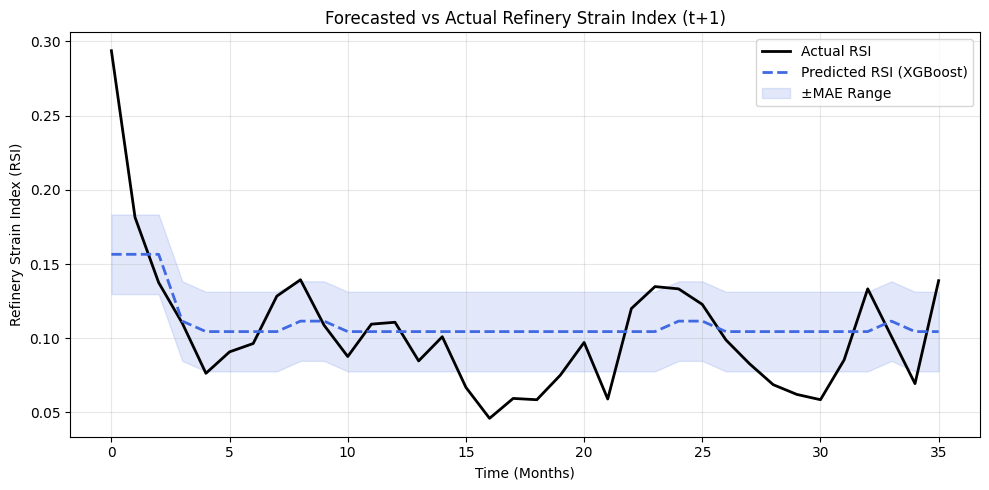

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

mae = 0.0268  # from your results

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual RSI", color="black", linewidth=2)
plt.plot(y_pred, label="Predicted RSI (XGBoost)", color="royalblue", linestyle="--", linewidth=2)
plt.fill_between(range(len(y_pred)),
                 y_pred - mae, y_pred + mae,
                 color="royalblue", alpha=0.15, label="±MAE Range")

plt.title("Forecasted vs Actual Refinery Strain Index (t+1)")
plt.xlabel("Time (Months)")
plt.ylabel("Refinery Strain Index (RSI)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()